In [1]:
import mrcfile 
import numpy as np
import torchvision.datasets
import datetime
import os
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
# import transformers
import pytorch_lightning as pl
import supervision as sv
from transformers import DetrForObjectDetection, DetrImageProcessor, DetrForSegmentation
import torch
import sys 
sys.path.append("/home/tyfei/cyroem")
import importlib 
import utils
import matplotlib.pyplot as plt
from torchvision.transforms import v2
importlib.reload(utils)
torch.manual_seed(1509)
np.random.seed(1509)

In [2]:
DEVICE = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'
CHECKPOINT = "facebook/detr-resnet-50"
image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
# model = DetrForObjectDetection.from_pretrained("./checkpoints/test_detr.pth")
# model = DetrForObjectDetection.from_pretrained("./checkpoints/test_detr.pth")
# model.to(DEVICE)
# image_processor.do_rescale =False 
# image_processor.do_normalize
# image_processor.do_rescale=False

In [3]:
olddataset = utils.MyCocoDetection("/data/tyfei/datasets/cyroem/test4/Mean10", 
                        "/data/tyfei/datasets/cyroem/test4/npy_annotations.pkl",
                        is_npy=True,image_processor=image_processor)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:

dataset = utils.CocoDetection("/data/tyfei/datasets/cyroem/test4/Mean10", 
                        "/data/tyfei/datasets/cyroem/test4/npy_annotations.pkl",
                        is_npy=True, transform=utils.getDefaultTransform(), require_mask=True)
train_set, val_set = torch.utils.data.random_split(dataset, [0.8, 0.2])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
isinstance(dataset[22]["labels"]["boxes"], torch.Tensor)

True

In [20]:
dataset[22]["labels"]["boxes"]

tensor([[0.2850, 0.2488, 0.2725, 0.3100],
        [0.3275, 0.1550, 0.1875, 0.3100],
        [0.0969, 0.2669, 0.1937, 0.1838],
        [0.0500, 0.0887, 0.1000, 0.1775],
        [0.2862, 0.2244, 0.0150, 0.0137],
        [0.3475, 0.1744, 0.0025, 0.0012],
        [0.3325, 0.1063, 0.0025, 0.0050],
        [0.1112, 0.0806, 0.0150, 0.0162],
        [0.3769, 0.0512, 0.0137, 0.0175],
        [0.0919, 0.1006, 0.0012, 0.0012],
        [0.1900, 0.2738, 0.0175, 0.0200],
        [0.2856, 0.1325, 0.0188, 0.0225],
        [0.3975, 0.4100, 0.0175, 0.0175],
        [0.0319, 0.1887, 0.0137, 0.0150],
        [0.3944, 0.1069, 0.0213, 0.0188],
        [0.2369, 0.3625, 0.0162, 0.0225],
        [0.2544, 0.0756, 0.0188, 0.0188],
        [0.0656, 0.4300, 0.0188, 0.0225],
        [0.4162, 0.0856, 0.0100, 0.0213],
        [0.3438, 0.4000, 0.0225, 0.0200],
        [0.2531, 0.0938, 0.0162, 0.0150],
        [0.2713, 0.3575, 0.0125, 0.0125],
        [0.3688, 0.4031, 0.0150, 0.0113],
        [0.2681, 0.0237, 0.0162, 0

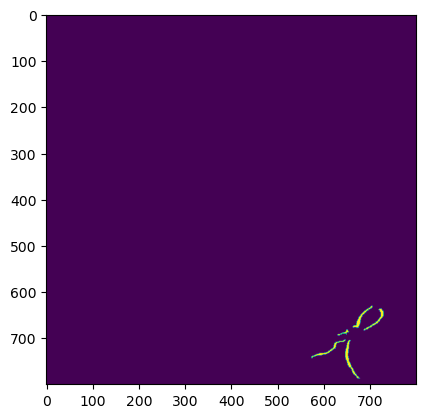

In [23]:
l1 = dataset[20]["labels"]["masks"][6]
l1 = l1.numpy()
plt.imshow(l1)

In [24]:
trainloader = DataLoader(dataset=train_set, collate_fn=utils.stackBatch, batch_size=2, shuffle=True, num_workers=4)
valloader = DataLoader(dataset=val_set, collate_fn=utils.stackBatch, batch_size=2, num_workers=4)
testloader = DataLoader(dataset=val_set, collate_fn=utils.stackBatch, batch_size=1)

In [25]:
ds = utils.EMDataModule(trainloader, valloader, testloader) 

In [26]:
for i, data in enumerate(trainloader):
    print(data["labels"][1]["masks"].shape)
    print(data["pixel_mask"].shape)
    break

torch.Size([1, 800, 800])
torch.Size([2, 800, 800])


In [27]:
data["pixel_mask"].dtype

torch.int64

In [28]:
categories = dataset.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

In [29]:
pretrain = DetrForSegmentation.from_pretrained(
            pretrained_model_name_or_path='facebook/detr-resnet-50', 
            num_labels=len(id2label),
            ignore_mismatched_sizes=True, 
            num_queries=200,
        )

Some weights of DetrForSegmentation were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized: ['model.bbox_attention.k_linear.bias', 'model.bbox_attention.k_linear.weight', 'model.bbox_attention.q_linear.bias', 'model.bbox_attention.q_linear.weight', 'model.detr.bbox_predictor.layers.0.bias', 'model.detr.bbox_predictor.layers.0.weight', 'model.detr.bbox_predictor.layers.1.bias', 'model.detr.bbox_predictor.layers.1.weight', 'model.detr.bbox_predictor.layers.2.bias', 'model.detr.bbox_predictor.layers.2.weight', 'model.detr.class_labels_classifier.bias', 'model.detr.class_labels_classifier.weight', 'model.detr.model.backbone.conv_encoder.model.bn1.bias', 'model.detr.model.backbone.conv_encoder.model.bn1.running_mean', 'model.detr.model.backbone.conv_encoder.model.bn1.running_var', 'model.detr.model.backbone.conv_encoder.model.bn1.weight', 'model.detr.model.backbone.conv_encoder.model.conv1.weight', 'model.detr.model.backbone.conv_encoder.model.la

In [30]:
state_dict = pretrain.state_dict()#.keys()
for i in list(state_dict.keys()):
    if "backbone" not in i:
        del state_dict[i] 
pretrain.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['detr.model.input_projection.weight', 'detr.model.input_projection.bias', 'detr.model.query_position_embeddings.weight', 'detr.model.encoder.layers.0.self_attn.k_proj.weight', 'detr.model.encoder.layers.0.self_attn.k_proj.bias', 'detr.model.encoder.layers.0.self_attn.v_proj.weight', 'detr.model.encoder.layers.0.self_attn.v_proj.bias', 'detr.model.encoder.layers.0.self_attn.q_proj.weight', 'detr.model.encoder.layers.0.self_attn.q_proj.bias', 'detr.model.encoder.layers.0.self_attn.out_proj.weight', 'detr.model.encoder.layers.0.self_attn.out_proj.bias', 'detr.model.encoder.layers.0.self_attn_layer_norm.weight', 'detr.model.encoder.layers.0.self_attn_layer_norm.bias', 'detr.model.encoder.layers.0.fc1.weight', 'detr.model.encoder.layers.0.fc1.bias', 'detr.model.encoder.layers.0.fc2.weight', 'detr.model.encoder.layers.0.fc2.bias', 'detr.model.encoder.layers.0.final_layer_norm.weight', 'detr.model.encoder.layers.0.final_layer_norm.bias', 'detr.model.encoder.lay

In [31]:
model = utils.Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4, model=pretrain)

In [32]:
import torch.utils.tensorboard

In [33]:
import tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [34]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
torch.set_float32_matmul_precision("high")
# %cd {HOME}

# settings
MAX_EPOCHS = 200

checkpoint_callback = ModelCheckpoint(
        monitor="validate_loss",  # Replace with your validation metric
        mode="min",  # 'min' if the metric should be minimized (e.g., loss), 'max' for maximization (e.g., accuracy)
        save_top_k=3,  # Save top k checkpoints based on the monitored metric
        save_last=True,  # Save the last checkpoint at the end of training
        dirpath="/home/tyfei/cyroem/checkpoints/detr_TS031_seg",  # Directory where the checkpoints will be saved
        filename="{epoch}-{validate_loss:.2f}",  # Checkpoint file naming pattern
    )
# pytorch_lightning >= 2.0.0
logger = TensorBoardLogger("tb_logs", "seg_T031")
trainer = Trainer(devices=[5], accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=4, log_every_n_steps=1, callbacks=[checkpoint_callback])

trainer.fit(model, ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type                | Params | Mode
-----------------------------------------------------
0 | model | DetrForSegmentation | 42.9 M | eval
-----------------------------------------------------
42.6 M    Trainable params
222 K     Non-trainable params
42.9 M    Total params
171.457   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


Detections(xyxy=array([[804.2222   ,   1.7199373, 840.4541   ,   1.7792783]],
      dtype=float32), mask=None, confidence=array([0.67741096], dtype=float32), class_id=array([3]), tracker_id=None, data={})


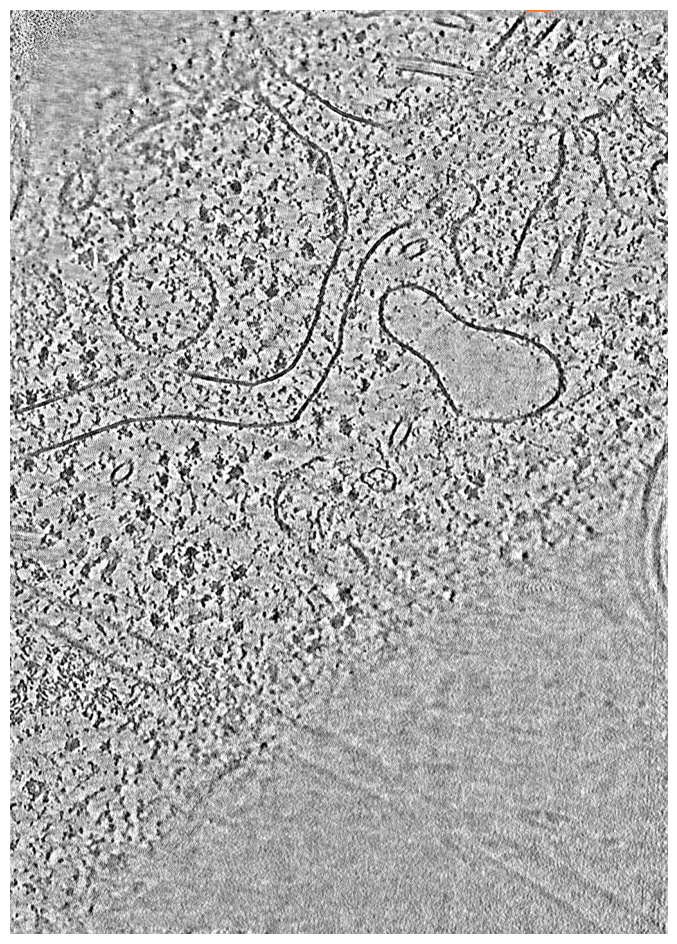

In [18]:
import mmcv
with torch.no_grad():

    # load image and predict
    # image = mmcv.imread("/data/tyfei/datasets/cyroem/test4/SingleChannelImage/TS_031_300.png")
    
    image = np.load("/data/tyfei/datasets/cyroem/test4/Mean10/TS_031_220.npy")
    inputs = image_processor(images=image, return_tensors='pt')
    outputs = model(pixel_values = inputs["pixel_values"], pixel_mask = inputs["pixel_mask"])

    # post-process
    target_sizes = torch.tensor([image.shape[:2]])
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=0.001, 
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results)
detections = detections.with_nms(threshold=0.5)
# labels = [
#     f" {confidence:0.2f}" 
#     for _, confidence, _, 
#     in detections
# ]

box_annotator = sv.BoxAnnotator()
print(detections)
# image = np.moveaxis(image, 0, -1)
image = mmcv.imread("/data/tyfei/datasets/cyroem/test4/SingleChannelImage/TS_031_220.png")
image = np.array(image)
# image = image*254 
# image = image.astype(np.uint8)
# print(image.shape)
frame = box_annotator.annotate(scene=image, detections=detections)

%matplotlib inline  
sv.plot_image(frame)

In [87]:
outputs.get()

DetrObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-1.6956,  1.5739, -2.0914,  ..., -0.9460, -2.4101,  8.5154],
         [-1.6389,  0.1836, -2.2143,  ..., -0.9046, -2.4602,  9.1427],
         [-1.8035,  0.0972, -2.2887,  ..., -0.8272, -2.4960,  9.0241],
         ...,
         [-1.8425,  0.4261, -2.7711,  ..., -1.0838, -2.6421,  9.0293],
         [-1.9257,  1.8898, -2.8787,  ..., -0.8506, -2.6398,  8.3732],
         [-1.7040,  0.4173, -2.5405,  ..., -1.0095, -2.5205,  9.0951]]]), pred_boxes=tensor([[[0.3327, 0.6195, 0.0316, 0.0649],
         [0.5507, 0.4830, 0.0614, 0.0588],
         [0.4192, 0.7697, 0.1837, 0.0880],
         [0.6573, 0.4368, 0.0322, 0.0323],
         [0.4611, 0.5061, 0.1161, 0.0672],
         [0.5527, 0.6868, 0.0901, 0.0879],
         [0.5325, 0.5890, 0.0453, 0.0567],
         [0.4119, 0.6307, 0.0601, 0.0570],
         [0.3231, 0.5153, 0.0657, 0.0400],
         [0.3523, 0.5542, 0.1173, 0.0486],
         [0.7334, 0.7613, 0.0284, 0.0568],
         [0.4

(1440, 1024, 3)

(3, 1440, 1024)

In [52]:
image.shape

(1440, 1024, 3)

In [1]:
image.shape

NameError: name 'image' is not defined

In [26]:
model.model.save_pretrained("./checkpoints/test_detr.pth")

In [31]:
pixel_values.shape

torch.Size([2, 3, 1125, 800])

In [35]:
import matplotlib.pyplot as plt
image = pixel_values[1]
image = image.swapaxis(1,2,0)
plt.imshow(pixel_values)

AttributeError: 'Tensor' object has no attribute 'swapaxis'

In [ ]:
CONFIDENCE_TRESHOLD

In [89]:
data["pixel_values"].shape

torch.Size([1, 3, 1125, 800])

0
(1125, 800, 3)


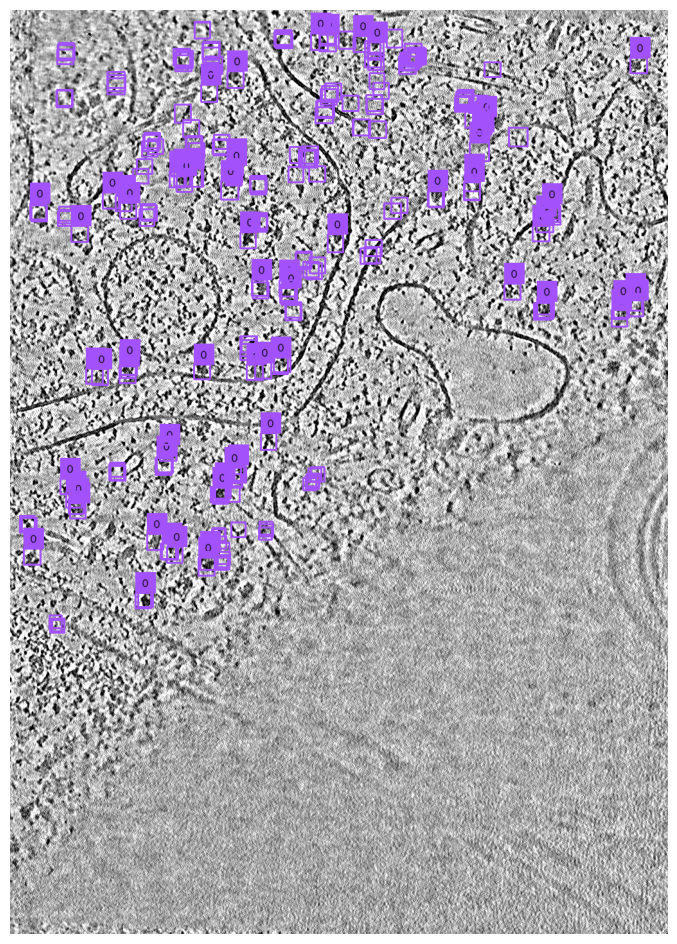

In [110]:
TEST_DATALOADER = DataLoader(dataset=val_set, collate_fn=collate_fn, batch_size=1)
CONFIDENCE_TRESHOLD = 0.001
with torch.no_grad():
    for i, data in enumerate(TEST_DATALOADER):
        print(i)
        pixel_values = data["pixel_values"]
        pixel_mask = data["pixel_mask"]
        # inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask) 
        target_sizes = torch.tensor([(1440, 1024)])
        results = image_processor.post_process_object_detection(
            outputs=outputs, 
            threshold=CONFIDENCE_TRESHOLD, 
            target_sizes=target_sizes
        )
        # print(results)
        detections = sv.Detections.from_transformers(transformers_results=results[0]) 
        

        # labels = [
        #     f"{confidence:0.2f}" 
        #     for _, confidence, _, _ 
        #     in detections
        # ]
        # print(detections)
        pixel_values = pixel_values.squeeze().cpu().permute(1,2,0).numpy()
        pixel_values = (pixel_values - np.min(pixel_values))
        pixel_values = (pixel_values/np.max(pixel_values)*255).astype(int)
        print(pixel_values.shape)
        t = np.ones_like(image)
        t[:1125, :800] = pixel_values
        box_annotator = sv.BoundingBoxAnnotator()
        # frame = box_annotator.annotate(scene=image, detections=detections)
        frame = box_annotator.annotate(scene=image, detections=detections)
        sv.plot_image(frame)
        break

In [62]:
detections

Detections(xyxy=array([[0.11823547, 0.39088923, 0.14197266, 0.4076646 ],
       [0.3895429 , 0.21414119, 0.41329995, 0.2315296 ],
       [0.23264372, 0.5799845 , 0.25658265, 0.59738165],
       [0.5404741 , 0.03610551, 0.56507677, 0.05301825],
       [0.30308607, 0.18336192, 0.32699403, 0.20090276],
       [0.39589334, 0.37637338, 0.41963434, 0.39325425],
       [0.3340002 , 0.4918776 , 0.35745832, 0.5088046 ],
       [0.25225195, 0.44554675, 0.27603683, 0.4615814 ],
       [0.25310585, 0.17191973, 0.276853  , 0.18909037],
       [0.10993156, 0.0876119 , 0.13416089, 0.10438971],
       [0.5436652 , 0.268131  , 0.5672798 , 0.28644362],
       [0.11977094, 0.39068997, 0.14365464, 0.4073013 ],
       [0.8036715 , 0.25232926, 0.82830167, 0.26789722],
       [0.76093197, 0.28331336, 0.7848675 , 0.2994316 ],
       [0.30729252, 0.5171901 , 0.33100307, 0.5325382 ],
       [0.17331997, 0.13291931, 0.1975125 , 0.15111935],
       [0.09893696, 0.09102406, 0.12233445, 0.10708459],
       [0.70159

In [54]:
import torch.nn as nn
out_logits, out_bbox = outputs.logits, outputs.pred_boxes
prob = nn.functional.softmax(out_logits, -1)
scores, labels = prob[..., :-1].max(-1)


In [59]:
scores

tensor([[0.0015, 0.0025, 0.0021, 0.0036, 0.0037, 0.0018, 0.0019, 0.0015, 0.0022,
         0.0033, 0.0018, 0.0022, 0.0015, 0.0023, 0.0019, 0.0023, 0.0025, 0.0017,
         0.0029, 0.0012, 0.0017, 0.0024, 0.0020, 0.0024, 0.0022, 0.0012, 0.0026,
         0.0015, 0.0023, 0.0015, 0.0015, 0.0019, 0.0019, 0.0028, 0.0012, 0.0015,
         0.0026, 0.0024, 0.0013, 0.0023, 0.0027, 0.0030, 0.0023, 0.0017, 0.0023,
         0.0015, 0.0021, 0.0012, 0.0016, 0.0017, 0.0041, 0.0035, 0.0018, 0.0019,
         0.0014, 0.0022, 0.0014, 0.0016, 0.0014, 0.0019, 0.0021, 0.0024, 0.0030,
         0.0025, 0.0040, 0.0024, 0.0016, 0.0013, 0.0017, 0.0024, 0.0031, 0.0012,
         0.0015, 0.0019, 0.0019, 0.0018, 0.0013, 0.0015, 0.0020, 0.0027, 0.0022,
         0.0017, 0.0018, 0.0046, 0.0015, 0.0023, 0.0025, 0.0028, 0.0011, 0.0019,
         0.0012, 0.0027, 0.0012, 0.0028, 0.0016, 0.0014, 0.0026, 0.0042, 0.0014,
         0.0017]])

In [24]:
pixel_values.shape

(1125, 800, 3)

In [19]:
pixel_values = pixel_values.squeeze().cpu().permute(1,2,0).numpy()
pixel_values = (pixel_values - np.min(pixel_values))
pixel_values = pixel_values/np.max(pixel_values)

In [16]:
pixel_values.shape

torch.Size([2, 3, 1125, 800])

In [39]:
frame = box_annotator.annotate(scene=image.cpu().numpy(), detections=detections, labels=labels)
sv.plot_image(frame)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
